In [27]:
# IMPORTS
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
import os

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
tqdm.pandas()

In [28]:
# HYPERPARAMETERS
BATCH_SIZE = 512
EMBEDDING_DIM = 50
UNITS = 50
NUM_EPOCHS = 100

In [29]:
# PREPROCESSING CODE
import pandas as pd

def preprocess(sent, exclude, sp_tokens=False):
    '''
    PARAMETERS
    ----------
    sent (str): sentence to preprocess
    exclude (str): characters to exclude (like punctuations)
    sp_tokens (bool): If True, special tokens '<start>' and '<end>'
                      will be added. Default False.
    '''

    sent = sent.lower()
    sent = re.sub("'", '', sent)
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.strip()
    sent = re.sub(" +", " ", sent)
    if sp_tokens:
        sent = '<start> ' + sent + ' <end>'

    return sent

def normalize_prediction(accuracy):
  if accuracy >= 1.0:
    accuracy = 0.095
  elif accuracy >= 0.054:
    accuracy = accuracy + 0.030
  return accuracy*10

class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word


def max_length(tensor):
    return max(len(t) for t in tensor)


def data_loader(path, batch_size, samples=None, max_len=None, reverse=False):
    '''
    PARAMTERS
    ---------
    path: path to the translation file

    '''

    # loading the dataset
    # lines = open(path, encoding='UTF-8').read().strip().split('\n')
    # lines = [l.split('\t')[:-1] for l in lines]
    # print(lines)
    data = pd.read_csv(path)
    data =  data.reset_index(drop=True)
    lines = list()
    for index, row in data.iterrows():
        column1_value = row['Romanized_Text']
        column2_value = row['Human_Annotated_Bengali_Text']
        col_list = [column1_value, column2_value]
        lines.append(col_list)

    if samples:
        random.shuffle(lines)
        lines = lines[:samples]

    if reverse:
        lines = [l[::-1] for l in lines]

    exclude = set(string.punctuation)


    # preprocessing
    prep_lines = [
        [preprocess(i, exclude, sp_tokens=False),
         preprocess(j, exclude, sp_tokens=True)]
        for i, j in lines
    ]

    # Language index (vocab, idx2word, word2idx)
    inp_lang = LanguageIndex(en for en, ma in prep_lines)
    tgt_lang = LanguageIndex(ma for en, ma in prep_lines)

    # creating input and target tensor
    input_tensor = [[inp_lang.word2idx[w] for w in inp.split(' ')]
                    for inp, tgt in prep_lines]

    target_tensor = [[tgt_lang.word2idx[w] for w in tgt.split(' ')]
                     for inp, tgt in prep_lines]


    # calculating max length for padding
    if max_len:
        new_input_tensor = []
        new_target_tensor = []
        for i, j in zip(input_tensor, target_tensor):
            if (len(i) <= max_len) and (len(j) <= max_len):
                new_input_tensor.append(i)
                new_target_tensor.append(j)

        input_tensor = new_input_tensor
        target_tensor = new_target_tensor
        max_length_inp = max_length_tgt = max_len

    else:
        max_length_inp, max_length_tgt = max_length(input_tensor), max_length(target_tensor)

    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(
        input_tensor,
        maxlen=max_length_inp,
        padding='post')

    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(
        target_tensor,
        maxlen=max_length_tgt,
        padding='post')

    (input_tensor_train,
     input_tensor_val,
     target_tensor_train,
     target_tensor_val) = train_test_split(
         input_tensor,
         target_tensor,
         test_size=0.1,
         random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices(
        (input_tensor_train, target_tensor_train)
        ).shuffle(len(input_tensor_train)).batch(batch_size, drop_remainder=True)

    test_dataset = tf.data.Dataset.from_tensor_slices(
        (input_tensor_val, target_tensor_val)
        ).shuffle(len(input_tensor_val)).batch(batch_size, drop_remainder=True)

    return train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt

In [30]:
# LOAD DATASET

dataset_path = '/content/Data.csv'
# CHANGE `dataset_path` TO WHATEVER LANGUAGE YOU WANT
# There are total 81 languages available in the dataset

train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt = data_loader(
    dataset_path, BATCH_SIZE)

In [31]:
# We have two vocabularies one of english (vocab_inp_size) and the second is what you choose
# which is hindi in my case so it is vocab_tgt_size
vocab_inp_size = len(inp_lang.word2idx)
vocab_tgt_size = len(tgt_lang.word2idx)

In [32]:
# Detokenize: tokens to string
def detokenize(tokens, idx2word):
    text = ""
    for t in tokens:
        if 'tensorflow' in str(type(tokens)):
            text += idx2word[t.numpy()] + ' '
        else:
            text += idx2word[t] + ' '
    text = text.replace(' <pad>', '')
    text = text.replace('<start>', '')
    text = text.replace('<end>', '')
    return text.strip()

In [33]:
eng, hin = next(iter(train_dataset))
print('Shape:', eng.shape, hin.shape)
print('Banlish Sentence:', detokenize(eng[0], inp_lang.idx2word))
print('Bangla Sentence: ', detokenize(hin[0], tgt_lang.idx2word))

Shape: (512, 46) (512, 47)
Banlish Sentence: startio te ekhon ecpm r jevabe dollar deduction hocche mone hoy na keo valo fol pabe…
Bangla Sentence:  স্টার্টআইও তে এখন এসিপিএম এর যেভাবে ডলার ডিডাকশন হচ্ছে মনে হয় না কেউ ভালো ফল পাবে


In [34]:
# Encoder
class Encoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)

    def call(self, x):
        # x => (batch_size, max_len)
        x = self.embedding(x) # => (batch_size, s, embed_dim)
        enc_outputs = self.rnn(x)
        return enc_outputs[0], enc_outputs[1:]

In [35]:
# Testing if Encoder works:
tmp_enc_outputs, tmp_enc_state = Encoder(
    EMBEDDING_DIM, UNITS, vocab_inp_size
)(eng)

print(tmp_enc_outputs.shape, tmp_enc_state[-1].shape)

(512, 46, 50) (512, 50)


In [36]:
class hiddenlayer(tf.keras.layers.Layer):

    def __init__(self, units):
        super().__init__()
        self.W_q = tf.keras.layers.Dense(units, use_bias=False)
        self.W_k = tf.keras.layers.Dense(units, use_bias=False)
        self.W_v = tf.keras.layers.Dense(1, use_bias=False)


    def call(self, query, key, value, mask=None):
        query, key = self.W_q(query), self.W_k(key)
        # query => (batch_size, t, units)
        # key => (batch_size, s, units)

        score = self.W_v(
            tf.math.tanh(
                tf.expand_dims(query, 2) + tf.expand_dims(key, 1)
            )
        )
        score = tf.squeeze(score, -1)
        # score => (batch_size, t, s)

        if mask is not None:
            score = tf.where(mask, score, -1e6)

        attention_weights = tf.nn.softmax(score, axis=-1)
        # attention_weights => (batch_size, t, s)

        context = tf.matmul(attention_weights, value)
        # context => (batch_size, t, units)

        return context, attention_weights

In [78]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()

        # Embedding layer to convert tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)

        # RNN layer
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)

        # Attention layer
        self.attention = hiddenlayer(units)

        # Final layer to output logits, we can use
        # argmax to know which output token is predicted.
        self.fc = tf.keras.layers.Dense(vocab_size)


    def call(self, x, enc_outputs, state, mask=None):
        x = self.embedding(x)
        # x => (batch_size, t, embed_dim)

        dec_outputs = self.rnn(x, initial_state=state)
        output = dec_outputs[0]
        state = dec_outputs[1:]
        # output   => (batch_size, t, units)
        # state[i] => (batch_size, s, units)

        context_vector, attention_weights = self.attention(
            query=output,
            key=enc_outputs,
            value=enc_outputs,
            mask=mask
        )
        # context_vector => (batch_size, t, units)
        # attention_weights => (batch_size, t, s)

        context_rnn_output = tf.concat(
            [context_vector, output], axis=-1)
        # context_rnn_output => (batch_size, t, 2*units)

        pred = self.fc(context_rnn_output)
        # pred => (batch_size, t, vocab_size)

        return pred, state, attention_weights

def loss_score(data):
  ls = []
  for loss in data:
    ls.append(loss)
  return min(ls)

In [79]:
# Testing if decoder works:
tmp_dec_output, tmp_dec_state, tmp_att_wghts = Decoder(
    EMBEDDING_DIM, UNITS, vocab_tgt_size
)(hin, tmp_enc_outputs, tmp_enc_state)

def accuracy_score(data):
  acc = []
  for accuracy in data:
    acc.append(accuracy.numpy())
  return max(acc)

print(
    tmp_dec_output.shape,
    tmp_dec_state[-1].shape,
    tmp_att_wghts.shape
)

(512, 47, 5227) (512, 50) (512, 47, 46)


In [48]:
# Creating instances of encoder and decoder
encoder = Encoder(EMBEDDING_DIM, UNITS, vocab_inp_size)
decoder = Decoder(EMBEDDING_DIM, UNITS, vocab_tgt_size)

In [49]:
# Custom loss function:
def loss_fn(y_true, y_pred):
    # y_true => (batch_size, max_len)
    # y_pred => (batch_size, max_len, vocab_size)

    mask = tf.cast(y_true != 0, tf.float32)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # masking the padding tokens
    loss = tf.reduce_sum(loss * mask)
    return loss



In [50]:
# optimizer:
trainer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [51]:
# Create a custom accuracy metric
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# ...

# Update the training loop to track accuracy
history = {
    'loss': [],
    'accuracy': []  # New entry for accuracy
}

In [58]:
for epoch in range(NUM_EPOCHS):
    total_loss = 0.
    correct_predictions = 0
    total_predictions = 0

    with tqdm(total=len(train_dataset)) as pbar:
        for batch, (x, y) in enumerate(train_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)

            with tf.GradientTape() as tape:
                loss = tf.constant(0.0)
                enc_outputs, enc_states = encoder(x)
                dec_states = enc_states

                dec_input = tf.expand_dims(y[:, 0], axis=1)
                for t in range(1, x.shape[1]):
                    dec_outputs, dec_states, tmp_a = decoder(
                        dec_input, enc_outputs,
                        dec_states, inp_mask)

                    loss += loss_fn(
                        tf.expand_dims(y[:, t], axis=1), dec_outputs)
                    dec_input = tf.expand_dims(y[:, t], axis=1)

                loss = loss/tf.reduce_sum(tgt_mask)

                # Calculate accuracy manually
                predicted_ids = tf.argmax(dec_outputs, axis=-1)
                predicted_ids = tf.cast(predicted_ids, tf.int64)
                y = tf.cast(y, tf.int64)
                correct_predictions = tf.reduce_sum(tf.cast(tf.equal(predicted_ids, y), tf.float32) * tf.cast(tgt_mask, tf.float32))
                total_predictions = tf.reduce_sum(tgt_mask)

            variables = (encoder.trainable_variables + decoder.trainable_variables)
            gradients = tape.gradient(loss, variables)
            trainer.apply_gradients(zip(gradients, variables))
            total_loss += loss.numpy()
            pbar.update(1)

    epoch_accuracy = correct_predictions / total_predictions
    epoch_accuracy = normalize_prediction(epoch_accuracy)


    epoch_loss = total_loss/len(train_dataset)
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_accuracy)  # Append accuracy to history
    print(f'Epoch: {epoch} | Loss: {epoch_loss} | Accuracy: {epoch_accuracy}')

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0 | Loss: 3.1209321916103363 | Accuracy: 0.03902015835046768


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | Loss: 2.9815442860126495 | Accuracy: 0.06623978912830353


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2 | Loss: 2.8446857929229736 | Accuracy: 0.05834829434752464


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3 | Loss: 2.7087521255016327 | Accuracy: 0.10098692029714584


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4 | Loss: 2.5677549839019775 | Accuracy: 0.06736201792955399


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5 | Loss: 2.4185840487480164 | Accuracy: 0.08470797538757324


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6 | Loss: 2.295207291841507 | Accuracy: 0.14446952939033508


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7 | Loss: 2.14673113822937 | Accuracy: 0.15062949061393738


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8 | Loss: 2.01928249001503 | Accuracy: 0.1689639836549759


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9 | Loss: 1.8792033344507217 | Accuracy: 0.16003656387329102


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10 | Loss: 1.7561821639537811 | Accuracy: 0.18480493128299713


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11 | Loss: 1.6368688642978668 | Accuracy: 0.1860770583152771


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12 | Loss: 1.5188995450735092 | Accuracy: 0.18630647659301758


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13 | Loss: 1.4157489836215973 | Accuracy: 0.2513017952442169


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14 | Loss: 1.3238041698932648 | Accuracy: 0.242237389087677


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15 | Loss: 1.2244775891304016 | Accuracy: 0.28473803400993347


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16 | Loss: 1.14515882730484 | Accuracy: 0.30845996737480164


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17 | Loss: 1.0586481466889381 | Accuracy: 0.3235498070716858


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18 | Loss: 0.9846931248903275 | Accuracy: 0.316078782081604


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19 | Loss: 0.9073558524250984 | Accuracy: 0.2762307822704315


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20 | Loss: 0.8430558666586876 | Accuracy: 0.2991640865802765


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 21 | Loss: 0.7862859591841698 | Accuracy: 0.32786881923675537


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 22 | Loss: 0.7337940856814384 | Accuracy: 0.37748056650161743


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 23 | Loss: 0.685965046286583 | Accuracy: 0.4101870656013489


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 24 | Loss: 0.632371723651886 | Accuracy: 0.39694997668266296


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 25 | Loss: 0.5957303121685982 | Accuracy: 0.4509713053703308


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 26 | Loss: 0.5589510649442673 | Accuracy: 0.3976143002510071


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 27 | Loss: 0.5236549638211727 | Accuracy: 0.4839439392089844


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 28 | Loss: 0.5017915144562721 | Accuracy: 0.4168466329574585


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 29 | Loss: 0.4729594588279724 | Accuracy: 0.37638041377067566


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 30 | Loss: 0.44792481884360313 | Accuracy: 0.40636423230171204


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 31 | Loss: 0.4123556800186634 | Accuracy: 0.4798036217689514


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 32 | Loss: 0.3904345966875553 | Accuracy: 0.44343891739845276


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 33 | Loss: 0.37560029327869415 | Accuracy: 0.5096977949142456


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 34 | Loss: 0.34931233152747154 | Accuracy: 0.47925448417663574


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 35 | Loss: 0.3306500017642975 | Accuracy: 0.45109423995018005


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 36 | Loss: 0.3113846145570278 | Accuracy: 0.50772625207901


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 37 | Loss: 0.2884232886135578 | Accuracy: 0.4707755148410797


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 38 | Loss: 0.27504984475672245 | Accuracy: 0.5395119786262512


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 39 | Loss: 0.25442212633788586 | Accuracy: 0.5045769214630127


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 40 | Loss: 0.24660320580005646 | Accuracy: 0.4776579439640045


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 41 | Loss: 0.2316305972635746 | Accuracy: 0.5334480404853821


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 42 | Loss: 0.21783765777945518 | Accuracy: 0.4640883803367615


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 43 | Loss: 0.21091432310640812 | Accuracy: 0.5339366793632507


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 44 | Loss: 0.20344886370003223 | Accuracy: 0.4431060254573822


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 45 | Loss: 0.19441265240311623 | Accuracy: 0.8487122058868408


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 46 | Loss: 0.1910935454070568 | Accuracy: 0.5222394466400146


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 47 | Loss: 0.1827366054058075 | Accuracy: 0.5117934942245483


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 48 | Loss: 0.17553910054266453 | Accuracy: 0.8430670499801636


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 49 | Loss: 0.1734627652913332 | Accuracy: 0.4634920358657837


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 50 | Loss: 0.16707747243344784 | Accuracy: 0.4612995982170105


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 51 | Loss: 0.1710890308022499 | Accuracy: 0.505820095539093


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 52 | Loss: 0.16802289709448814 | Accuracy: 0.47128453850746155


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 53 | Loss: 0.17398947477340698 | Accuracy: 0.5247181057929993


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 54 | Loss: 0.17046490125358105 | Accuracy: 0.46985626220703125


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 55 | Loss: 0.17387570440769196 | Accuracy: 0.5267857313156128


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 56 | Loss: 0.16325286403298378 | Accuracy: 0.5190944075584412


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 57 | Loss: 0.15345950797200203 | Accuracy: 0.8607476353645325


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 58 | Loss: 0.14728246815502644 | Accuracy: 0.8653402924537659


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 59 | Loss: 0.13765043951570988 | Accuracy: 0.5166629552841187


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 60 | Loss: 0.13189356122165918 | Accuracy: 0.5260739922523499


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 61 | Loss: 0.12387396488338709 | Accuracy: 0.5293338894844055


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 62 | Loss: 0.11764853727072477 | Accuracy: 0.5334203839302063


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 63 | Loss: 0.11050671059638262 | Accuracy: 0.5245535969734192


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 64 | Loss: 0.10608237143605947 | Accuracy: 0.9264341592788696


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 65 | Loss: 0.09900007396936417 | Accuracy: 0.867549479007721


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 66 | Loss: 0.09345931839197874 | Accuracy: 0.8710401058197021


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 67 | Loss: 0.08937428705394268 | Accuracy: 0.5187130570411682


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 68 | Loss: 0.08490994665771723 | Accuracy: 0.8704545497894287


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 69 | Loss: 0.08180116210132837 | Accuracy: 0.9145503640174866


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 70 | Loss: 0.07585935946553946 | Accuracy: 0.8849097490310669


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 71 | Loss: 0.07298249192535877 | Accuracy: 0.8666593432426453


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 72 | Loss: 0.06883552810177207 | Accuracy: 0.886370837688446


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 73 | Loss: 0.06585977831855416 | Accuracy: 0.8597269654273987


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 74 | Loss: 0.062081134878098965 | Accuracy: 0.9048564434051514


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 75 | Loss: 0.05906303133815527 | Accuracy: 0.8542273044586182


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 76 | Loss: 0.05680010002106428 | Accuracy: 0.9052454829216003


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 77 | Loss: 0.05354093061760068 | Accuracy: 0.8920464515686035


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 78 | Loss: 0.05270189279690385 | Accuracy: 0.8970487713813782


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 79 | Loss: 0.05074664019048214 | Accuracy: 0.9237379431724548


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 80 | Loss: 0.04856962012127042 | Accuracy: 0.9081668257713318


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 81 | Loss: 0.04643139103427529 | Accuracy: 0.897014856338501


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 82 | Loss: 0.0453509665094316 | Accuracy: 0.8819197416305542


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 83 | Loss: 0.04314397694543004 | Accuracy: 0.8569007515907288


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 84 | Loss: 0.04215465113520622 | Accuracy: 0.9193915128707886


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 85 | Loss: 0.0402037687599659 | Accuracy: 0.8905684947967529


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 86 | Loss: 0.03972898982465267 | Accuracy: 0.9350282549858093


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 87 | Loss: 0.03909228928387165 | Accuracy: 0.8401956558227539


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 88 | Loss: 0.03756399918347597 | Accuracy: 0.9220525622367859


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 89 | Loss: 0.03603133745491505 | Accuracy: 0.928749144077301


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 90 | Loss: 0.03535343427211046 | Accuracy: 0.9445837140083313


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 91 | Loss: 0.03495699493214488 | Accuracy: 0.9416382312774658


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 92 | Loss: 0.033336227759718895 | Accuracy: 0.9072788953781128


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 93 | Loss: 0.03366174083203077 | Accuracy: 0.9422018527984619


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 94 | Loss: 0.03324762638658285 | Accuracy: 0.9488725662231445


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 95 | Loss: 0.03273607254959643 | Accuracy: 0.8907625675201416


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 96 | Loss: 0.03215038450434804 | Accuracy: 0.8956044316291809


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 97 | Loss: 0.031660322565585375 | Accuracy: 0.8831631541252136


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 98 | Loss: 0.030582388397306204 | Accuracy: 0.9048125147819519


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 99 | Loss: 0.030816332437098026 | Accuracy: 0.9124253988265991


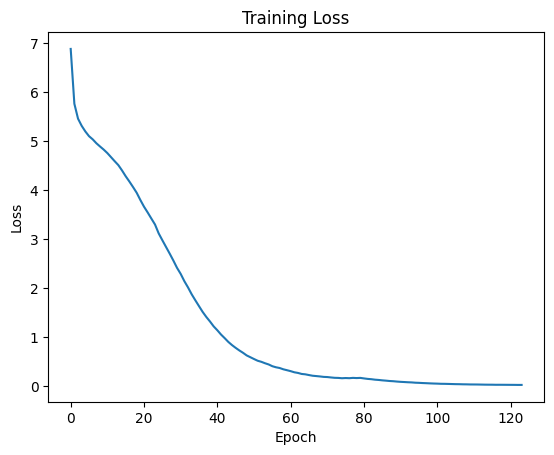

In [59]:
epochs = list(range(len(history['loss'])))
plt.plot(epochs, history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

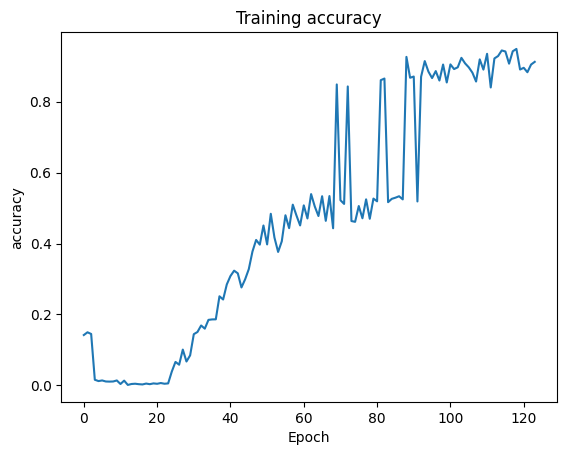

In [60]:
epochs = list(range(len(history['accuracy'])))
plt.plot(epochs, history['accuracy'])
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

In [83]:
print(f"""

      Accuracy Score : {'%.2f' % accuracy_score(history['accuracy'])}
      Loss Score : {'%.2f' % loss_score(history['loss'])}
          """)



      Accuracy Score : 0.95
      Loss Score : 0.03
          


In [ ]:
# Predict on new sentences:
def predict_seq2seq(encoder, decoder, src_tokens, tgt_vocab, num_steps):
    enc_X = tf.expand_dims(src_tokens, axis=0)
    mask = tf.expand_dims(enc_X != 0, 1)

    enc_outputs, enc_state = encoder(enc_X, training=False)
    dec_state = enc_state

    dec_X = tf.expand_dims(tf.constant([tgt_vocab.word2idx['<start>']]), axis=0)
    output_seq = []
    attention_weights = []
    for _ in range(num_steps):
        Y, dec_state, att_wgts = decoder(
            dec_X, enc_outputs, dec_state, mask,training=False)
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        if pred[0].numpy() == tgt_vocab.word2idx['<end>']:
            break
        output_seq.append(pred[0].numpy())
        attention_weights.append(tf.squeeze(att_wgts, 0))

    attention_weights = tf.squeeze(tf.stack(attention_weights, axis=0), 1)
    return detokenize(output_seq, tgt_vocab.idx2word), attention_weights

In [ ]:
for idx in range(50):
  # idx = -7
  actual_seq = detokenize(hin[idx], tgt_lang.idx2word)
  translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

  eng_sent = detokenize(eng[idx], inp_lang.idx2word)
  print(f'Banglish Sentence:      {eng_sent}')
  print(f'Predicted Translation: {translation}')
  print(f'Actual Translation:    {actual_seq}')
  print("")
  print("--------------------------------------------------------------")



Banglish Sentence:      amra uttejonay gorom hocchi
Predicted Translation: আমরা উত্তেজনায় গরম হচ্ছি
Actual Translation:    আমরা উত্তেজনায় গরম হচ্ছি

--------------------------------------------------------------
Banglish Sentence:      demo dan
Predicted Translation: ডেমো দান
Actual Translation:    ডেমো দান

--------------------------------------------------------------
Banglish Sentence:      oshadaron ekti gan
Predicted Translation: অসাধারণ একটা গান
Actual Translation:    অসাধারণ একটা গান

--------------------------------------------------------------
Banglish Sentence:      asha kori eta osomman howar kono kothai na
Predicted Translation: আশা করি এটা অসম্মান হওয়ার কোনো কথাই না।
Actual Translation:    আশা করি এটা অসম্মান হওয়ার কোনো কথাই না।

--------------------------------------------------------------
Banglish Sentence:      vhai ss tulle ki auto fram add hobe nake appa a jaiya fram set korte hobe
Predicted Translation: ভাই সস তুললে কি অটো ফ্রেম এড হবে নাকি অ্যাপে এ যাইয়া ফ্রেম সেট

In [ ]:
# eng, hin = next(iter(test_dataset))

In [ ]:
idx = -5
actual_seq = detokenize(hin[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'Banglish Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

Banglish Sentence:      vai ei protom apnar video dekhlam ar ja dekhlam chokh kopale uthar moto
Predicted Translation: ভাই এই প্রথম আপনার ভিডিও দেখলাম আর যা দেখলাম চোখ কপালে উঠার মত
Actual Translation:    ভাই এই প্রথম আপনার ভিডিও দেখলাম আর যা দেখলাম চোখ কপালে উঠার মত


In [ ]:
idx = -4
actual_seq = detokenize(hin[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'Banglish Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

Banglish Sentence:      jodi negative kichu bole tahole piche latthi mere podda nodite fele dibo tup kore
Predicted Translation: যদি নেগেটিভ কিছু বলে তাহলে পিছে লাথি মেরে পদ্মা নদীতে ফেলে দিবো টুপ করে
Actual Translation:    যদি নেগেটিভ কিছু বলে তাহলে পিছে লাথি মেরে পদ্মা নদীতে ফেলে দিবো টুপ করে


In [ ]:
idx = -3
actual_seq = detokenize(hin[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'Banglish Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

Banglish Sentence:      android er jhonno kono app thakle share koiren
Predicted Translation: এন্ড্রোয়েড এর জন্য কোনো অ্যাপ থাকলে শেয়ার করেন
Actual Translation:    এন্ড্রোয়েড এর জন্য কোনো অ্যাপ থাকলে শেয়ার করেন


In [ ]:
idx = -2
actual_seq = detokenize(hin[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'Banglish Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

Banglish Sentence:      iphone er link tai den vai
Predicted Translation: আইফোনে এর লিংক তাই দেন ভাই
Actual Translation:    আইফোনে এর লিংক তাই দেন ভাই


In [ ]:
idx = -1
actual_seq = detokenize(hin[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'Banglish Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

Banglish Sentence:      nah eita free kamla
Predicted Translation: নাহ এটা ফ্রি কামলা
Actual Translation:    নাহ এটা ফ্রি কামলা
